# Credit Card Fraud Detection — Cost-Sensitive Modeling
### End-to-end pipeline: EDA → Modeling → Threshold Optimization → Business Cost Evaluation

---

## Project Overview

This project implements a cost-sensitive fraud detection pipeline
using a highly imbalanced credit card transaction dataset (~0.17% fraud rate).

Given the extreme class imbalance, accuracy is not an appropriate evaluation metric.
Instead, the modeling process focuses on:

- Precision & Recall
- PR-AUC
- Threshold optimization
- Business cost trade-offs (False Positives vs False Negatives)

The goal is not only predictive performance, but minimizing expected business loss.

In [ ]:
# ======================
# Global Imports
# ======================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    auc,
    precision_score,
    recall_score,
    f1_score
)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("creditcard.csv")

# Display basic dataset information
df.head()

Dataset shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.info()

## Class Distribution Analysis

In [ ]:
# Absolute class counts
df["Class"].value_counts()


In [ ]:
# Class proportions
df["Class"].value_counts(normalize=True)

In [ ]:
# Fraud rate (mean of binary target)
fraud_rate = df["Class"].mean()
fraud_rate

The dataset is extremely imbalanced (~0.17% fraud cases).

This means that predicting all transactions as non-fraud would already yield ~99.8% accuracy.

Therefore, accuracy is not an appropriate evaluation metric.
We focus instead on Precision, Recall, PR-AUC, and threshold optimization
to reflect real-world business trade-offs.


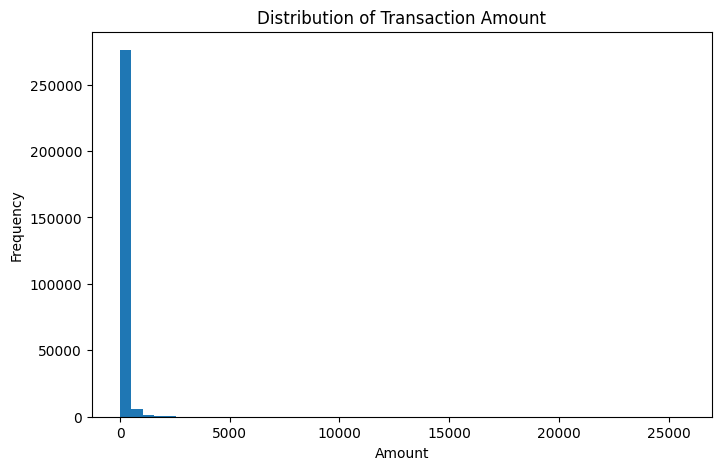

In [4]:
plt.figure(figsize=(8, 5))
plt.hist(df["Amount"], bins=50, edgecolor="black")
plt.title("Distribution of Transaction Amount")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


The distribution of transaction amounts is heavily right-skewed.
Most transactions are small, while a small number of extreme high-value outliers create a long right tail.

Such skewness can negatively impact linear models,
suggesting the need for transformation (e.g., log scaling).


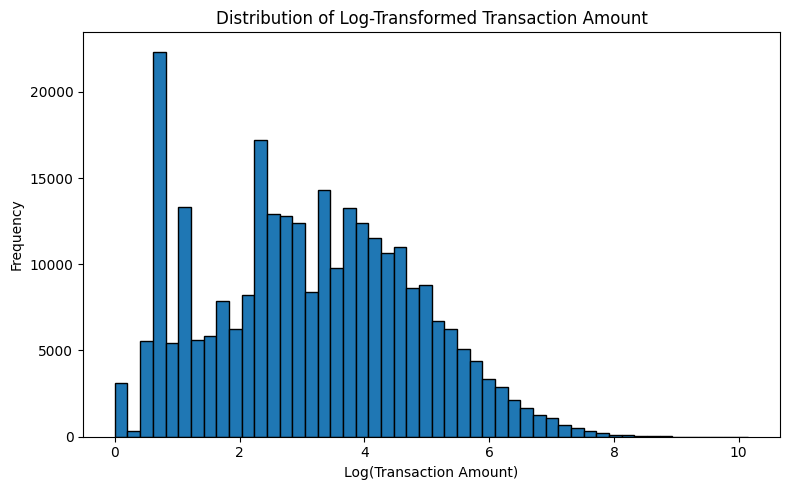

In [18]:
# Apply log transformation to reduce right-skewness
df["Log_Amount"] = np.log1p(df["Amount"])

plt.figure(figsize=(8, 5))
plt.hist(df["Log_Amount"], bins=50, edgecolor="black")
plt.title("Distribution of Log-Transformed Transaction Amount")
plt.xlabel("Log(Transaction Amount)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## Log Transformation of Transaction Amount

The original transaction amount distribution was heavily right-skewed.
Applying a log transformation significantly reduces skewness and compresses extreme outliers.

This transformation improves numerical stability and is particularly important
for linear models such as Logistic Regression.


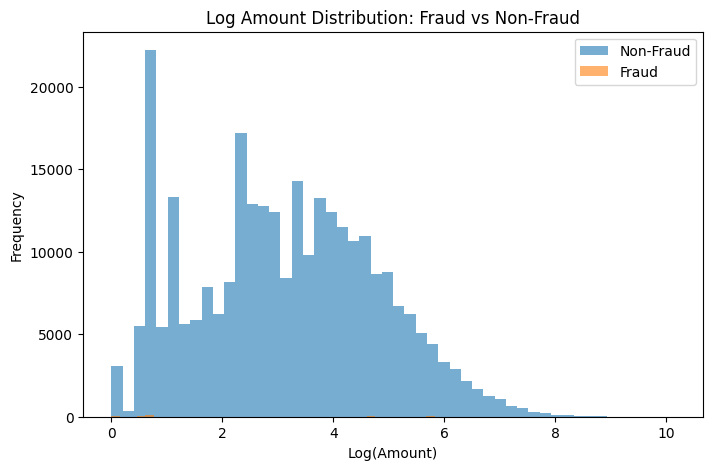

In [6]:
plt.figure(figsize=(8, 5))

plt.hist(
    df[df["Class"] == 0]["Log_Amount"],
    bins=50,
    alpha=0.6,
    density=True,
    label="Non-Fraud"
)

plt.hist(
    df[df["Class"] == 1]["Log_Amount"],
    bins=50,
    alpha=0.6,
    density=True,
    label="Fraud"
)

plt.title("Log(Transaction Amount): Fraud vs Non-Fraud")
plt.xlabel("Log(Transaction Amount)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(8, 5))

plt.hist(df[df["Class"] == 0]["Log_Amount"],
         bins=50,
         alpha=0.6,
         label="Non-Fraud",
         density=True)

plt.hist(df[df["Class"] == 1]["Log_Amount"],
         bins=50,
         alpha=0.6,
         label="Fraud",
         density=True)

plt.title("Log(Transaction Amount): Fraud vs Non-Fraud (Normalized)")
plt.xlabel("Log(Transaction Amount)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


### Fraud vs Non-Fraud: Log Amount Comparison

Fraud transactions occur across the full range of transaction amounts.

While there is a mild shift toward smaller transaction values, there is no clear separation between fraud and non-fraud based on amount alone.

This suggests that transaction amount is not a strong standalone signal, but can still contribute when combined with other features.



## Transition from EDA to Modeling

The exploratory analysis showed:

- The dataset is extremely imbalanced (~0.17% fraud).
- Transaction amounts are highly right-skewed.
- Fraud transactions appear across all amount ranges, with no clear separation based solely on amount.

Given these observations, we proceed to build a baseline classification model.
We will use Logistic Regression as a starting point and evaluate it using metrics appropriate for imbalanced datasets.


## Train-Test Split

We split the data into training and test sets using stratification
to preserve the original class imbalance in both subsets.

In [ ]:
# Features and target
X = df.drop(columns=["Class"])
y = df["Class"]

# Train-test split (stratified because of imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
pd.DataFrame({
    "Split": ["Train", "Test"],
    "Rows": [X_train.shape[0], X_test.shape[0]],
    "Fraud Rate": [y_train.mean(), y_test.mean()]
})

## Baseline Model — Logistic Regression

We start with a simple Logistic Regression baseline using the default threshold (0.5).
This provides a reference point before applying feature scaling and threshold optimization.

In [ ]:
# Initialize model
model = LogisticRegression(max_iter=1000)

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

pd.DataFrame(confusion_matrix(y_test, y_pred),
             index=["Actual 0", "Actual 1"],
             columns=["Predicted 0", "Predicted 1"])
print(classification_report(y_test, y_pred, digits=3))


### Baseline Model Evaluation (Logistic Regression)

The baseline model achieves:

- Recall (Fraud): 71%
- Precision (Fraud): 81%

This means the model correctly detects 71% of fraudulent transactions, while 19% of flagged transactions are false positives.

Although overall accuracy is very high due to class imbalance, Recall and Precision are more meaningful metrics in this context.


## Feature Scaling — StandardScaler

Logistic Regression is sensitive to feature scaling.  
We apply StandardScaler to ensure features are centered and standardized.

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_scaled = LogisticRegression(max_iter=1000)

model_scaled.fit(X_train_scaled, y_train)

y_pred_scaled = model_scaled.predict(X_test_scaled)

pd.DataFrame(
    confusion_matrix(y_test, y_pred_scaled),
    index=["Actual: Non-Fraud", "Actual: Fraud"],
    columns=["Pred: Non-Fraud", "Pred: Fraud"]
)
print(classification_report(y_test, y_pred_scaled, digits=3))

### Effect of Feature Scaling

Feature scaling leads to small shifts in Precision and Recall.
This reflects the trade-off between detecting more fraud cases
and reducing false positives.


In [ ]:
# Get predicted probabilities
y_probs = model_scaled.predict_proba(X_test_scaled)[:, 1]

## From Model Performance to Threshold Optimization

Even with scaling, the default threshold (0.5) may not be optimal
for highly imbalanced and cost-sensitive fraud detection.

We now analyze predicted probabilities and optimize the decision threshold.

## Business Cost-Based Threshold Evaluation

Beyond Precision and Recall, fraud detection systems must
account for asymmetric business costs.

In real-world fraud detection systems, missing a fraudulent transaction (False Negative) is typically far more costly than generating a false alert (False Positive).


At a lower threshold (e.g., 0.1):

- Recall increases substantially  
- Precision decreases moderately  
- F1-score improves compared to the default threshold  

This highlights the trade-off between sensitivity and false alarm control.


To simulate a realistic fraud detection setting,
we assume that missing a fraudulent transaction (False Negative)
is significantly more costly than raising a false alarm (False Positive).


In [ ]:
cost_fn = 1000
cost_fp = 10

thresholds = [0.5, 0.3, 0.1, 0.05, 0.01]

best_threshold = None
min_cost = float("inf")

for t in threshold_grid:
    y_pred_custom = (y_probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_custom).ravel()
    total_cost = fn * cost_fn + fp * cost_fp

    if total_cost < min_cost:
        min_cost = total_cost
        best_threshold = t

print(f"Optimal Threshold: {best_threshold:.4f}")
print(f"Minimum Business Cost: ${min_cost}")

## Business-Driven Threshold Selection

To align the model with business impact, we simulate asymmetric error costs:

- False Negative (missed fraud) cost: $1000  
- False Positive (false alarm) cost: $10  

We evaluate multiple decision thresholds and compute the total expected cost:

Total Cost = FN * 1000 + FP * 10

Among the tested thresholds, **0.01 minimizes the total business cost**, indicating that in this setting it is preferable to tolerate more false alarms in order to reduce expensive missed fraud cases.


In [ ]:
cost_fn = 1000
cost_fp = 10

threshold_grid = np.linspace(0.0001, 0.2, 200)

best_t = None
best_cost = float("inf")
best_fp = None
best_fn = None

for t in threshold_grid:
    y_pred_custom = (y_probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_custom).ravel()
    total_cost = fn * cost_fn + fp * cost_fp

    if total_cost < best_cost:
        best_cost = total_cost
        best_t = t
        best_fp = fp
        best_fn = fn

print(f"Best threshold: {best_t:.4f}")
print(f"Best total cost: ${best_cost}")
print(f"FP: {best_fp}, FN: {best_fn}")


## Optimal Threshold Based on Business Cost

Instead of relying on arbitrary threshold values, we perform a grid search to minimize expected business cost.

Using the assumed cost structure:

- False Negative cost: $1000  
- False Positive cost: $10  

The optimal threshold is:

**0.0162**

This reduces the total expected business cost to **$11,900**, significantly lower than the default 0.5 threshold.

This demonstrates that optimal fraud detection requires business-aligned threshold tuning rather than relying on default model settings.


In [ ]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs)

pr_auc = auc(recall, precision)

pr_auc

## Precision-Recall Performance

Given the extreme class imbalance (~0.17% fraud rate), Precision-Recall metrics are more informative than accuracy or ROC-AUC.

The model achieves:

**PR-AUC = 0.7366**

This indicates strong performance in distinguishing fraudulent transactions from legitimate ones, especially considering the highly imbalanced nature of the dataset.


## Final Conclusions

This project demonstrates a full end-to-end fraud detection workflow:

- Exploratory data analysis of highly imbalanced data
- Baseline Logistic Regression model
- Feature scaling
- Threshold tuning
- Business cost optimization
- Precision-Recall evaluation

Key insight:
The optimal decision threshold is not 0.5.
Business-aligned threshold selection significantly reduces total expected cost.

## Next Steps (Production Considerations)

In a real-world deployment, the following steps would be required:

- Continuous monitoring of model performance
- Regular retraining to handle concept drift
- Calibration of predicted probabilities
- Integration with a real-time transaction scoring system
- Human review pipeline for flagged transactions
